In [1]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [2]:

import cv2
import math

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.fromnumeric import size
from matplotlib import colors
from asgiref.sync import sync_to_async #in order to load variables to communicate between sync and async

import optimal_path as op

from robot import Robot
from Map import Map
from Local_navigation import* 
from Mouvement import*
from vision import*
from optimal_path import* 


map_lenght = 1
nb_of_square_by_side = 50
current = 1

global move 
move = False #bool which indicate how our robot is moving (1: avoid an object VS 0: following the optimal path)
kalman_bool = False
old_distance = 0
old_angle = 0
#pourcentage_reduc = 1

In [3]:

George = Robot()
Lausanne = Map(map_lenght, nb_of_square_by_side)

#VideoCap = vision_initialization()
VideoCap=cv2.VideoCapture(0)


In [4]:
@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500, verbose=False):
    """
    Sets the motor speeds of the Thymio 
    param l_speed: left motor speed
    param r_speed: right motor speed
    param verbose: whether to print status messages or not
    """
    global motor_left_target, motor_right_target
    # Printing the speeds if requested
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    motor_left_target = l_speed
    motor_right_target = r_speed

taille frame (480, 640, 3)
MAP INITIALISATION
goal (53, 18)
start position (34, 18)
Resized Dimensions :  (66, 50)
PATH COMPUTATION
PATH [[34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
  58 59 59 59 59 59 59 58 57 56 55 54 53]
 [18 18 17 16 15 14 13 12 11 10  9  9  9  9  9  9  9  9  8  8  8  8  8  8
   9 10 11 12 13 14 15 16 16 17 17 17 18]]
PATH22222 [[34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
  58 59 59 59 59 59 59 58 57 56 55 54 53]
 [18 18 17 16 15 14 13 12 11 10  9  9  9  9  9  9  9  9  8  8  8  8  8  8
   9 10 11 12 13 14 15 16 16 17 17 17 18]]


True

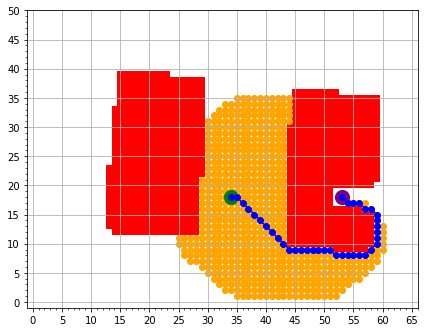

In [5]:
np.set_printoptions(threshold=sys.maxsize)
####################################
## INIT
####################################

# Prend une première image
ret, frame = VideoCap.read()
print("taille frame", frame.shape)

print("MAP INITIALISATION")
# Set the pourcentage value between the nb of pixel and nb of square by side
Lausanne.set_map_lenght(frame)
#print("Pourcentage",Lausanne.get_pourcentage())
# Set the robot goal, position and angle
goal = init_goal(frame, Lausanne.get_pourcentage())
#goal = (50, 40)
pos_robot = George.get_pos()
#print("GOAL", goal)


#pos_robot, angle = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
 
      #Utiliser au cas où il ne trouve pas la bonne position du premier coup
while (pos_robot[0] <= 0) & (pos_robot[1] <= 0):
    #ret, frame=VideoCap.read()
    #display(frame,1,0,0)
    ret, frame=VideoCap.read()
    #vs.display (frame, 0, 1, 1, 0, 5, Lausanne.get_pourcentage())
    pos_robot, angle = update(frame, Lausanne.get_pourcentage())  # fonction qui retourne la position angle etc....
    #print("Waiting robot position") 
 

George.set_angle(angle)
George.set_goal(goal)
George.set_start_pos(pos_robot)
George.set_pos(pos_robot)
print ("goal", goal)
print ("start position", pos_robot)

# SET MAP
Lausanne.set_map_lenght(frame)
#print("Lausanna lenght", Lausanne.get_lenght())

# MASK 
mask = mask_map_init(frame)
#cv2.imshow("mask", mask)
cv2.imwrite("masque1.jpg", mask)

# Fin de l'init
Lausanne.init_grid(mask)
grille = Lausanne.get_map()
#cv2.imshow("grid", grille)
cv2.imwrite("grille.jpg", grille)

# OPTIMAL PATH
print("PATH COMPUTATION")
path, visitedNodes = op.path_computation(George.get_start() , George.get_goal() , Lausanne.get_lenght(), grille)

George.set_path(path) 
George.set_visit_nodes(visitedNodes) 

# Display the optimal path
op.display_map(Lausanne.get_lenght(),  grille,  George.get_visit_nodes(), George.get_path(), George.get_start(), George.get_goal())
print("PATH", George.get_path())

display (frame, 0, 1, 1, 1, George.get_path(), Lausanne.get_pourcentage())
print("PATH22222", George.get_path())
cv2.imwrite("TOTAL.jpg", frame)

#vision_end(VideoCap)



In [6]:

####################################
## while
####################################

George.set_current(0)
current= 0
kalman_bool = False
print("PATH", George.get_path())
old_distance = 0
old_angle = 0

print('START MOUVEMENT')
while True:#(George.get_pos() != George.get_goal()):
    
    # Read the camera
    ret, frame=VideoCap.read()
    
    # Recupere la position et angle --> XAV
    pos_robot,angle_robot = update(frame, Lausanne.get_pourcentage())
    George.set_pos(pos_robot)
    George.set_angle(angle_robot)
    
    if(current < George.get_path().shape[1]-1):
        current = path_update(pos_robot, 3, np.transpose(George.get_path())[current], George.get_current())
        George.set_current(current)
    else:
        print("ARRIVED")
        motors(0,0)
        break
    
    #print("pos", pos_robot)
    print("taille", George.get_path().shape[1])
    print("current", current)
    pos_goal =  np.transpose(George.get_path())[current]
    speed_l, speed_r, old_distance, old_goal  = move_to_position(pos_robot, angle_robot, pos_goal, old_distance, old_angle)

    motors(speed_l, speed_r) 
    
    display (frame, 0, 1, 1, 1, path, Lausanne.get_pourcentage())
    
    # Quit when we press q
    keyVal = cv2.waitKey(1) & 0xFF
    if keyVal == ord('q'):
        motors(0,0)
        break
     
    sleep(0.1)


print("The End")
    

PATH [[34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
  58 59 59 59 59 59 59 58 57 56 55 54 53]
 [18 18 17 16 15 14 13 12 11 10  9  9  9  9  9  9  9  9  8  8  8  8  8  8
   9 10 11 12 13 14 15 16 16 17 17 17 18]]
START MOUVEMENT
PATH [34 18]
X 0
Y 0
next goal plz
taille 37
current 1
(34, 18)
debut 34 18 -2.784680717238123
dist_debut 1.0
angle_goal, 0.0
2.784680717238123
alpha 2.784680717238123
v 2.0
w 501.24252910286214
speed_original, -429 573
speed, 0 0
PATH [35 18]
X 1
Y 0
next goal plz
taille 37
current 2
(34, 18)
debut 34 18 -2.7954566900204325
dist_debut 2.23606797749979
angle_goal, 5.81953769817878
8.614994388199213
alpha 2.3318090810196264
v 4.47213595499958
w 419.7256345835327
speed_original, -345 494
speed, -345 200
PATH [36 17]
X 7
Y 1
taille 37
current 2
(29, 16)
debut 29 16 0.3699060674565575
dist_debut 7.0710678118654755
angle_goal, 0.14189705460416438
-0.22800901285239314
alpha -0.22800901285239314
v 14.142135623730951
w -41.041622313430764
speed

PATH [39 14]
X 0
Y 3
taille 37
current 5
(39, 17)
debut 39 17 3.0598082729717975
dist_debut 3.0
angle_goal, 4.71238898038469
1.6525807074128922
alpha 1.6525807074128922
v 6.0
w 297.46452733432056
speed_original, -221 373
speed, -221 200
PATH [39 14]
X 6
Y 3
taille 37
current 5
(33, 17)
debut 33 17 0.15660187698201544
dist_debut 6.708203932499369
angle_goal, 5.81953769817878
5.662935821196765
alpha -0.6202494859828216
v 13.416407864998739
w -111.64490747690787
speed_original, 195 -28
speed, 195 -28
PATH [39 14]
X 5
Y 3
taille 37
current 5
(34, 17)
debut 34 17 0.19362199285594545
dist_debut 5.830951894845301
angle_goal, 5.742765806909002
5.549143814053057
alpha -0.7340414931265296
v 11.661903789690601
w -132.12746876277532
speed_original, 213 -50
speed, 200 -50
PATH [39 14]
X 0
Y 4
taille 37
current 5
(39, 18)
debut 39 18 -2.9476335063299004
dist_debut 4.0
angle_goal, 4.71238898038469
7.66002248671459
alpha 1.3768371795350038
v 8.0
w 247.83069231630068
speed_original, -169 325
speed, -16

PATH [39 14]
X 1
Y 4
taille 37
current 5
(38, 18)
debut 38 18 0.193959147259893
dist_debut 4.123105625617661
angle_goal, 4.957367643511554
4.763408496251661
alpha -1.5197768109279253
v 8.246211251235321
w -273.55982596702654
speed_original, 351 -195
speed, 200 -195
PATH [39 14]
X 1
Y 4
taille 37
current 5
(38, 18)
debut 38 18 0.03844259002118792
dist_debut 4.123105625617661
angle_goal, 4.957367643511554
4.918925053490366
alpha -1.3642602536892203
v 8.246211251235321
w -245.56684566405966
speed_original, 323 -167
speed, 200 -167
PATH [39 14]
X 1
Y 5
taille 37
current 5
(38, 19)
debut 38 19 -0.16820677185708632
dist_debut 5.0990195135927845
angle_goal, 4.90978454023457
5.077991312091656
alpha -1.2051939950879298
v 10.198039027185569
w -216.93491911582737
speed_original, 297 -136
speed, 200 -136
PATH [39 14]
X 4
Y 3
taille 37
current 5
(43, 17)
debut 43 17 2.8926299477970763
dist_debut 5.0
angle_goal, 3.7850937623830774
0.8924638145860011
alpha 0.8924638145860011
v 10.0
w 160.643486625480

PATH [39 14]
X 3
Y 3
taille 37
current 5
(42, 17)
debut 42 17 -2.0596486811226447
dist_debut 4.242640687119285
angle_goal, 3.9269908169872414
5.986639498109886
alpha -0.2965458090697002
v 8.48528137423857
w -53.37824563254603
speed_original, 131 25
speed, 131 25
PATH [39 14]
X 3
Y 2
taille 37
current 5
(42, 16)
debut 42 16 -2.0988707752212563
dist_debut 3.605551275463989
angle_goal, 3.7295952571373605
5.828466032358617
alpha -0.4547192748209694
v 7.211102550927978
w -81.8494694677745
speed_original, 159 -4
speed, 159 -4
PATH [39 14]
X 3
Y 2
taille 37
current 5
(42, 16)
debut 42 16 -2.1692152202734336
dist_debut 3.605551275463989
angle_goal, 3.7295952571373605
5.898810477410795
alpha -0.3843748297687921
v 7.211102550927978
w -69.18746935838257
speed_original, 146 8
speed, 146 8
PATH [39 14]
X 3
Y 2
taille 37
current 5
(42, 16)
debut 42 16 -2.2367655641740063
dist_debut 3.605551275463989
angle_goal, 3.7295952571373605
5.966360821311367
alpha -0.31682448586821943
v 7.211102550927978
w -57

PATH [42 11]
X 3
Y 1
taille 37
current 8
(39, 12)
debut 39 12 -1.5526165117219184
dist_debut 3.1622776601683795
angle_goal, 5.961434752782944
7.514051264504863
alpha 1.2308659573252763
v 6.324555320336759
w 221.55587231854975
speed_original, -145 297
speed, -145 200
PATH [42 11]
X 4
Y 1
taille 37
current 8
(38, 12)
debut 38 12 -1.3661545169651186
dist_debut 4.123105625617661
angle_goal, 6.038206644052722
7.404361161017841
alpha 1.1211758538382544
v 8.246211251235321
w 201.81165369088578
speed_original, -123 280
speed, -123 200
PATH [42 11]
X 4
Y 1
taille 37
current 8
(38, 12)
debut 38 12 -1.2776094302370145
dist_debut 4.123105625617661
angle_goal, 6.038206644052722
7.315816074289737
alpha 1.0326307671101502
v 8.246211251235321
w 185.87353807982706
speed_original, -107 264
speed, -107 200
PATH [42 11]
X 4
Y 0
taille 37
current 8
(38, 11)
debut 38 11 -1.148791296892679
dist_debut 4.0
angle_goal, 0.0
1.148791296892679
alpha 1.148791296892679
v 8.0
w 206.7824334406822
speed_original, -128 

PATH [46  9]
X 3
Y 1
taille 37
current 12
(43, 10)
debut 43 10 -0.26791042242333984
dist_debut 3.1622776601683795
angle_goal, 5.961434752782944
6.229345175206284
alpha -0.053840131973302285
v 6.324555320336759
w -9.691223755194411
speed_original, 86 66
speed, 86 66
PATH [46  9]
X 2
Y 1
next goal plz
taille 37
current 13
(44, 10)
debut 44 10 -0.30970294454245645
dist_debut 3.1622776601683795
angle_goal, 5.961434752782944
6.2711376973254005
alpha -0.012047609854185681
v 6.324555320336759
w -2.168569773753423
speed_original, 78 74
speed, 78 74
PATH [47  9]
X 3
Y 1
taille 37
current 13
(44, 10)
debut 44 10 -0.2860514417173179
dist_debut 3.1622776601683795
angle_goal, 5.961434752782944
6.2474861945002615
alpha -0.03569911267932424
v 6.324555320336759
w -6.425840282278363
speed_original, 82 69
speed, 82 69
PATH [47  9]
X 3
Y 1
taille 37
current 13
(44, 10)
debut 44 10 -0.291456794477867
dist_debut 3.1622776601683795
angle_goal, 5.961434752782944
6.252891547260811
alpha -0.030293759918775143


PATH [54  8]
X 3
Y 1
taille 37
current 20
(51, 9)
debut 51 9 -0.291456794477867
dist_debut 3.1622776601683795
angle_goal, 5.961434752782944
6.252891547260811
alpha -0.030293759918775143
v 6.324555320336759
w -5.452876785379526
speed_original, 81 70
speed, 81 70
PATH [54  8]
X 3
Y 1
taille 37
current 20
(51, 9)
debut 51 9 -0.30400093934014444
dist_debut 3.1622776601683795
angle_goal, 5.961434752782944
6.265435692123089
alpha -0.017749615056497692
v 6.324555320336759
w -3.1949307101695847
speed_original, 79 73
speed, 79 73
PATH [54  8]
X 3
Y 0
taille 37
current 20
(51, 8)
debut 51 8 -0.291456794477867
dist_debut 3.0
angle_goal, 0.0
0.291456794477867
alpha 0.291456794477867
v 6.0
w 52.46222300601606
speed_original, 23 128
speed, 23 128
PATH [54  8]
X 2
Y 0
next goal plz
taille 37
current 21
(52, 8)
debut 52 8 -0.291456794477867
dist_debut 3.0
angle_goal, 0.0
0.291456794477867
alpha 0.291456794477867
v 6.0
w 52.46222300601606
speed_original, 23 128
speed, 23 128
PATH [55  8]
X 3
Y 0
taille

PATH [59 11]
X 0
Y 3
taille 37
current 26
(59, 8)
debut 59 8 1.1606689862534056
dist_debut 3.0
angle_goal, 1.5707963267948966
0.4101273405414909
alpha 0.4101273405414909
v 6.0
w 73.82292129746837
speed_original, 2 149
speed, 2 149
PATH [59 11]
X 0
Y 2
next goal plz
taille 37
current 27
(59, 9)
debut 59 9 1.2618655828711551
dist_debut 3.0
angle_goal, 1.5707963267948966
0.3089307439237414
alpha 0.3089307439237414
v 6.0
w 55.60753390627346
speed_original, 20 131
speed, 20 131
PATH [59 12]
X 0
Y 3
taille 37
current 27
(59, 9)
debut 59 9 1.2924966677897851
dist_debut 3.0
angle_goal, 1.5707963267948966
0.27829965900511144
alpha 0.27829965900511144
v 6.0
w 50.093938620920056
speed_original, 25 126
speed, 25 126
PATH [59 12]
X 0
Y 3
taille 37
current 27
(59, 9)
debut 59 9 1.3542460218188073
dist_debut 3.0
angle_goal, 1.5707963267948966
0.2165503049760893
alpha 0.2165503049760893
v 6.0
w 38.979054895696066
speed_original, 37 114
speed, 37 114
PATH [59 12]
X 1
Y 3
taille 37
current 27
(60, 9)
de

PATH [56 17]
X 3
Y 1
taille 37
current 33
(59, 16)
debut 59 16 2.397267268782799
dist_debut 3.1622776601683795
angle_goal, 2.819842099193151
0.42257483041035204
alpha 0.42257483041035204
v 6.324555320336759
w 76.06346947386336
speed_original, 0 152
speed, 0 152
PATH [56 17]
X 3
Y 1
taille 37
current 33
(59, 16)
debut 59 16 2.439335722080786
dist_debut 3.1622776601683795
angle_goal, 2.819842099193151
0.3805063771123649
alpha 0.3805063771123649
v 6.324555320336759
w 68.49114788022568
speed_original, 7 144
speed, 7 144
PATH [56 17]
X 2
Y 1
next goal plz
taille 37
current 34
(58, 16)
debut 58 16 2.494200513849864
dist_debut 3.1622776601683795
angle_goal, 2.819842099193151
0.3256415853432868
alpha 0.3256415853432868
v 6.324555320336759
w 58.61548536179162
speed_original, 17 134
speed, 17 134
PATH [55 17]
X 3
Y 1
taille 37
current 34
(58, 16)
debut 58 16 2.548242507433075
dist_debut 3.1622776601683795
angle_goal, 2.819842099193151
0.2715995917600762
alpha 0.2715995917600762
v 6.3245553203367

In [7]:
vision_end(VideoCap)

In [8]:
motors(0,0)